# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [132]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle
import math

#Set random seed
np.random.seed(1606)

### Functions

In [133]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

### 1. Import Vectors and Pre-Process them

In [134]:
# Import Gofunc vec file
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [135]:
df.head()

,ID,Vector
0,MESH:D012559,"[1.76247600e-02, -1.05403718e-02, -4.61959302e..."
1,MESH:D009404,"[0.01795662, 0.13640046, 0.03051887, -0.100085..."
2,MESH:D001749,"[-8.68742093e-02, 8.83234814e-02, -2.54237115e..."
3,MESH:D011471,"[-0.00926186, 0.04098112, -0.4911138, -0.22025..."
4,MESH:D008106,"[-0.12722802, 0.07976454, -0.5775048, -0.28237..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [136]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [137]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [138]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [139]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
1,C028474,MESH:D005355,"[-4.32693306e-03, 1.35906458e-01, -1.91942360e...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1


In [140]:
len(id_list)

3137

In [141]:
chem_dis.shape

(8651, 2)

In [142]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [143]:
df_dis

,ID,Vector
0,MESH:D012559,"[1.76247600e-02, -1.05403718e-02, -4.61959302e..."
1,MESH:D009404,"[0.01795662, 0.13640046, 0.03051887, -0.100085..."
2,MESH:D001749,"[-8.68742093e-02, 8.83234814e-02, -2.54237115e..."
3,MESH:D011471,"[-0.00926186, 0.04098112, -0.4911138, -0.22025..."
4,MESH:D008106,"[-0.12722802, 0.07976454, -0.5775048, -0.28237..."
5,MESH:D020178,"[-1.06008202e-02, 1.04818255e-01, -1.35847256e..."
6,OMIM:616339,"[0.0096043, 0.12845682, 0.03771714, -0.1297339..."
7,MESH:D012640,"[-0.03748654, 0.07145654, -0.31174418, -0.1745..."
8,MESH:D013631,"[0.02205224, 0.1162138, -0.06232823, -0.130196..."
9,MESH:C567046,"[0.03917132, 0.13197485, 0.05394781, -0.147766..."


In [144]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)   # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  8650
(17301, 5)
(17145, 5)


In [145]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotype Vecs
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [146]:
## First we'll add DOIDs for diseases and CIDs for chemicals as an intermediate for adding phenotypes
# Read in CSV mapping chems to CID and dis to DOID --> This file is created by phens-opa2vec.ipynb
mapper = pd.read_csv('entities.lst')

# Make the maps from this
dis_map = dict(zip(mapper.ID, mapper.DOID))
chem_map = dict(zip(mapper.ID, mapper.CID))

# Apply the maps to df1
df1['DOID'] = df1.DiseaseID.map(lambda x: dis_map.get(x))
df1['CID'] = df1.ChemicalID.map(lambda x: chem_map.get(x))

In [147]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,DOID:684,5382.0
1,C028474,MESH:D005355,"[-0.00432693306, 0.135906458, -0.019194236, -0...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382.0
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382.0
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382.0
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382.0


In [148]:
# Read in the association files from Sara
dis_phens = pd.read_csv('Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])
chem_phens =  pd.read_csv('Drug-PhenotypeAssocation.txt', sep=' ', names=['CID', 'Phenotype'])

In [149]:
# The association files have a different format for each ID system than mine, homogenise these
# first chem
def cid_standardiser (cid):
    # Must be format CID + 9 int chars, starting with 1 seemingly
    cid = int(cid)
    output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return output

df1['CID'] = df1.CID.map(lambda x: np.nan if math.isnan(x) else cid_standardiser(x))

In [150]:
# Export the chemical list, this will be used to ensure validation test sets don't overlap with this db
np.savetxt(r'chemsInNN.txt', df1.CID, fmt='%s')

In [151]:
sider_mod.ChemicalID.unique()# and now disease 
def doid_standardiser (doid):
    # Must be format DOID_ + ...
    # I'm unsure about how well this is working so print out the DOIDs that don't match
    doid = doid.replace(':', '_')
#     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
    return doid

df1['DOID'] = df1.DOID.map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [152]:
# Don't uncomment, unnceessary
# # Now that the DOIDs and CIDs are theoretically standardised we can chuck in the phens to df1

# # First though check which DOIDs and CIDs do not match up --> SEEMS OK
# test_doids = df1[df1.DOID.map(lambda x: isinstance(x, str))].DOID.tolist()
# imported_doids = dis_phens.DOID.tolist()
# for item in test_doids:
#     if item not in imported_doids:
#         print(item)                            

In [153]:
# Let's create one associations file for each ontology (I believe we need to run HP and MP separately)
chem_phens.columns = ['ID', 'Phen']
dis_phens.columns = ['ID', 'Phen']

# Maps for Split into MP/HP
hp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
hp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
mp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

total_hp = chem_phens[hp_df_crit_c].append(dis_phens[hp_df_crit_d], ignore_index=True)
total_mp = chem_phens[mp_df_crit_c].append(dis_phens[mp_df_crit_d], ignore_index=True)

In [154]:
total_mp.head()

,ID,Phen
0,CID100000085,<http://purl.obolibrary.org/obo/MP_0005036>
1,CID100000085,<http://purl.obolibrary.org/obo/MP_0003360>
2,CID100000085,<http://purl.obolibrary.org/obo/MP_0001636>
3,CID100000085,<http://purl.obolibrary.org/obo/MP_0001363>
4,CID100000085,<http://purl.obolibrary.org/obo/MP_0001664>


In [155]:
# Export the association files and print some stats (more stats later)
np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

print('Num HP associations: ', total_hp.shape[0])
print('Num MP associations: ', total_mp.shape[0])
print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))
print('Num MP associations for just diseases: ', total_mp[total_mp.ID.map(lambda x: 'CID' not in x)].shape[0])
print('Num HP associations for just diseases: ', total_hp[total_hp.ID.map(lambda x: 'CID' not in x)].shape[0])

Num HP associations:  277300
Num MP associations:  111742
Num ents with MP phen assocs:  8942
Num ents with HP phen assocs:  9126
Num MP associations for just diseases:  88633
Num HP associations for just diseases:  193000


In [156]:
# Create entities.lst to inform opa2vec which entities we want vectors for
entities = total_mp.ID.unique().tolist()
np.savetxt(r'entities_mp.lst', entities, fmt='%s')

entities = total_hp.ID.unique().tolist()
np.savetxt(r'entities_hp.lst', entities, fmt='%s')

### Run OPA2VEC for entity-phens

In [157]:
# HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [158]:
# # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [159]:
# Now import and integrate the vecs (all phen stuff above here should be in its own notebook )
# Import vec file
with open('hpvecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
hp_vecs = pd.DataFrame(text)
hp_vecs.columns = ['ID', 'Vector']

# Clean
hp_vecs = hp_vecs.dropna()
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [160]:
# Now import and integrate the mp vecs
# Import vec file
with open('mpvecs.lst', 'r') as file:
    text = file.read()

# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
mp_vecs = pd.DataFrame(text)
mp_vecs.columns = ['ID', 'Vector']

# Clean
mp_vecs = mp_vecs.dropna()
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [161]:
# Right, now I have hp and mp vecs, match them up into df1

In [162]:
# Make Maps:
mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

# Map entities to vecs (one set of vecs for mp and another for hp)
df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [163]:
## TODO note that I have removed rows without gofuncVecs, maybe now they should be kept
# Print Stats
print('Note these numbers include both correlated and uncorrelated pairs')
print('Number of rows with gofuncs: ', df1.shape[0]) ##NB change this if keeping rows w/o gofunc vecs
print('Number of rows with dis mp vec: ', df1[df1.disPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with dis hp vec: ', df1[df1.disPhenVecHP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem mp vec: ', df1[df1.chemPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with chem hp vec: ', df1[df1.chemPhenVecHP.map(lambda x: x is not None)].shape[0])
no_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is None) & df1.disPhenVecMP.map(lambda x: x is None)
no_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is None) & df1.chemPhenVecMP.map(lambda x: x is None)
no_phen_vecs = no_dis_phen_vecs & no_chem_phen_vecs
print('Number of rows with no phen vecs: ', df1[no_phen_vecs].shape[0])
all_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is not None) & df1.disPhenVecMP.map(lambda x: x is not None)
all_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is not None) & df1.chemPhenVecMP.map(lambda x: x is not None)
all_vecs = all_dis_phen_vecs & all_chem_phen_vecs
all_vecs_pos_corr = all_vecs & df1.Correlation.map(lambda x: x == 1)
all_vecs_neg_corr = all_vecs & df1.Correlation.map(lambda x: x == 0)
no_phen_vecs_corr = no_phen_vecs & df1.Correlation.map(lambda x: x == 1)
no_phen_vecs_uncorr = no_phen_vecs & df1.Correlation.map(lambda x: x == 0)



print('Number of rows with everything', df1[all_vecs].shape[0])

print('Number of correlated pairs with phenvecs', df1[no_phen_vecs_corr].shape[0])
print('Number of uncorrelated pairs with phenvecs', df1[no_phen_vecs_uncorr].shape[0])


print('Number of correlated pairs with everything', df1[all_vecs_pos_corr].shape[0])
print('Number of uncorrelated pairs with everything', df1[all_vecs_neg_corr].shape[0])

print('total pos corr', df1[df1.Correlation.map(lambda x: x == 1)].shape[0])
print('total neg corr', df1[df1.Correlation.map(lambda x: x == 0)].shape[0])

Note these numbers include both correlated and uncorrelated pairs
Number of rows with gofuncs:  17145
Number of rows with dis mp vec:  7079
Number of rows with dis hp vec:  7088
Number of rows with chem mp vec:  2770
Number of rows with chem hp vec:  2846
Number of rows with no phen vecs:  8529
Number of rows with everything 1279
Number of correlated pairs with phenvecs 3027
Number of uncorrelated pairs with phenvecs 5502
Number of correlated pairs with everything 1059
Number of uncorrelated pairs with everything 220
total pos corr 8595
total neg corr 8550


In [164]:
# Add empty vecs for rows that don't have phen vecs
empty_vec = [0] * 200

for col in ['disPhenVecMP', 'disPhenVecHP', 'chemPhenVecHP', 'chemPhenVecMP']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [165]:
# Change the Phen vec elements from string to floats
df1['disPhenVecHP'] = df1.disPhenVecHP.map(lambda x: [float(i) for i in x])
df1['disPhenVecMP'] = df1.disPhenVecMP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecHP'] = df1.chemPhenVecHP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecMP'] = df1.chemPhenVecMP.map(lambda x: [float(i) for i in x])

### Add CHEBI Vecs

In [166]:
# First add CHEBI IDs for each chem

In [167]:
# chem_names = df1.ChemicalID.unique().tolist()
# np.savetxt(r'chem_names', total_hp.values, fmt='%s')

In [168]:
# To add chebi first need CID for ALL Chems so I made this comprehensive map:
# Load the map from pickle object
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

ctd_cid_map = load_obj('ctd_cid_map')

In [169]:
df1['CID'] = df1.ChemicalID.map(lambda x: ctd_cid_map.get(x))

In [170]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP
1341,C017947,MESH:D008175,"[-0.0498087, 0.08013102, -0.21025404, -0.14221...","[-0.0531880707, 0.0433869548, -0.196800679, -0...",1,DOID_3905,b'443495',"[0.0438675731, 0.153149575, 0.0684680566, -0.1...","[0.03999165, 0.145569, 0.0636293, -0.1037104, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9741,C582340,MESH:D013617,"[0.05696682, 0.09369084, -0.0048688, -0.089769...","[0.03923435, 0.10083519, 0.0233496, -0.1123369...",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8458,D014673,MESH:D007022,"[-0.07060508, 0.08438816, -0.0596953, -0.07784...","[0.0453479178, 0.138363615, -0.0531766899, -0....",1,NaN,b'39764',"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02038578, 0.11926291, 0.05529715, -0.122521...","[0.03689281, 0.13800456, 0.05547665, -0.123047..."


In [171]:
# Convert CIDS from bytes to strings and export in order to make a map from CID to CHEBI ID
df1['CID'] = df1.CID.str.decode("utf-8")
np.savetxt(r'allCIDs.txt', df1.CID.unique(), fmt='%s')

## NOTE the next step is MANUAL you need to upload this allCIDs.txt to http://cts.fiehnlab.ucdavis.edu/batch 
# and download it as ctd_chebi.csv to the current folder

In [172]:
# How many chemicals don't have CIDs? Hence don't get chebi vecs
print(df1.shape[0])
print(df1[df1.CID.map(lambda x: x is not None)].shape[0])

17145
15148


In [173]:
# Import CSV mapping CID to CHEBI
ctdChebdf = pd.read_csv('ctd_chebi.csv')

# Turn it into a dict
ctd_chebi = dict(zip(ctdChebdf['PubChem CID'], ctdChebdf['ChEBI']))

# Map the cids to chebis
df1['CHEBI'] = df1.CID.map(lambda x: ctd_chebi.get(x))
df1['CHEBI'] = df1.CHEBI.map(lambda x: None if x == 'No result' else x)

In [174]:
# Now make CHEBI vecs using the CHEBI IDs
# First an association file - just linking each chebi to its own chebi entity

# add uri col
df1['CHEBI_uri'] = df1.dropna(subset=['CHEBI']).CHEBI.map(lambda x: '<http://purl.obolibrary.org/obo/' + x.replace(':', '_') + '>')

# export association file from df
np.savetxt(r'CHEBIassociations.txt', df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().values, fmt='%s')

# Now an entities file
chems_for_cheb = df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().ChemicalID.tolist()
np.savetxt(r'CHEBIentities.txt', chems_for_cheb, fmt='%s')

In [175]:
# Commenting this out now that I already have the vectors, you'll need it if you don't have them
# # Now run opa2vec on it 
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/chebi.owl -associations ../msc-thesis/opa/CHEBIassociations.txt -entities ../msc-thesis/opa/CHEBIentities.txt -outfile ../msc-thesis/opa/chebi-vecs.lst)', shell=True)

In [176]:
# Import Gofunc vec file
with open('chebi-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (ChemID to CHEBIvec)
chem_to_chebi_vec = dict(zip(df.ID, df.Vector))

In [177]:
df1['CHEBIvec'] = df1.ChemicalID.map(lambda x: chem_to_chebi_vec.get(x))

In [178]:
chem

'D003999'

In [179]:
# How many rows have CHEBI Vecs?
print('Total Rows', df1.shape[0])
print('Total Correlated Rows', df1[df1.Correlation == 1].shape[0])
print('Total CHEBI vec rows', df1.dropna(subset=['CHEBIvec']).shape[0])
print('Total CHEBI vec correlated rows', df1[df1.Correlation == 1].dropna(subset=['CHEBIvec']).shape[0])
print('Total Chems', len(df1.ChemicalID.unique()))
print('Total Chems with CHEBI Vec', len(df1.dropna(subset=['CHEBIvec']).ChemicalID.unique()))

Total Rows 17145
Total Correlated Rows 8595
Total CHEBI vec rows 10660
Total CHEBI vec correlated rows 5894
Total Chems 570
Total Chems with CHEBI Vec 316


In [180]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec
7769,D011794,MESH:D009133,"[0.03116769, 0.13587785, 0.04433348, -0.132408...","[-0.02145532, 0.06948259, -0.1081144, -0.14960...",1,DOID_767,5280343,"[0.025967028, 0.142268777, 0.066210404, -0.147...","[0.04816369, 0.14606375, 0.05307954, -0.107326...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",CHEBI:16243,<http://purl.obolibrary.org/obo/CHEBI_16243>,"[0.01221674, 0.05984232, 0.03748447, -0.071131..."
13468,C012655,MESH:D012608,"[0.01731185, 0.11330543, 0.07036374, -0.148131...","[0.00528433267, 0.0889950693, 0.0519304797, -0...",0,DOID_5434,4495,"[0.03662067, 0.14778006, 0.05885815, -0.139689...","[0.03258642, 0.12822168, 0.05323575, -0.108937...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,None
15111,C509592,MESH:C535780,"[0.01960866, 0.12501125, 0.04490718, -0.128422...","[0.00356502, 0.11017938, -0.02927761, -0.08686...",0,NaN,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,None


In [181]:
# Add empty vecs for rows that don't have Chebi vecs
empty_vec = [0] * 200
df1['CHEBIvec'] = df1['CHEBIvec'].map(lambda x: empty_vec if x is None else x)

# Change the Chebi vec elements from string to floats
df1['CHEBIvec'] = df1.CHEBIvec.map(lambda x: [float(i) for i in x])

### Add DO Vecs

In [182]:
# Import Gofunc vec file
with open('do-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [disease, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
dis_to_DOvec = dict(zip(df.ID, df.Vector))

In [183]:
df1['DOvec'] = df1.DiseaseID.map(lambda x: dis_to_DOvec.get(x))

In [184]:
# print(df1[df1.DOvec])

In [185]:
# Change the DO vec elements from string to floats
df1['DOvec'] = df1.DOvec.map(lambda x: [float(i) for i in x])

### ADD HINO vecs
This file is getting a bit long 

In [186]:
# Import HINO vec file
with open('hinoVecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
entity_to_HINOvec = dict(zip(df.ID, df.Vector))

In [187]:
df1['dis_HINOvec'] = df1.DiseaseID.map(lambda x: entity_to_HINOvec.get(x))
df1['chem_HINOvec'] = df1.ChemicalID.map(lambda x: entity_to_HINOvec.get(x))

In [188]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
8456,D014673,MESH:D009336,"[-0.0526574999, 0.0888598338, -0.0274056457, -...","[0.0453479178, 0.138363615, -0.0531766899, -0....",1,NaN,39764,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02038578, 0.11926291, 0.05529715, -0.122521...","[0.03689281, 0.13800456, 0.05547665, -0.123047...",CHEBI:9940,<http://purl.obolibrary.org/obo/CHEBI_9940>,"[0.021671124, 0.054821689, 0.015866555, -0.062...","[0.00657024048, 0.0294857603, 0.0133342622, -0...","[0.01687758, 0.05776156, 0.030141, -0.0418261,...",None
9347,D014800,MESH:D006106,"[-0.00255577127, 0.137570068, 0.0328803249, -0...","[-0.032665316, 0.00784736034, -0.240696847, -0...",0,DOID_2999,73357729,"[0.03042895, 0.15250877, 0.08092121, -0.129971...","[0.04462426, 0.15155883, 0.0598216, -0.1149215...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01823139, 0.07595742, 0.03893859, -0.067706...",None,None
1660,D013755,MESH:D006332,"[-0.01857389, 0.08952068, 0.00152742, -0.07504...","[-0.0382574834, -0.00508174021, -0.34883213, -...",1,NaN,27924,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",CHEBI:37537,<http://purl.obolibrary.org/obo/CHEBI_37537>,"[0.00174453, 0.07634099, 0.03278957, -0.074206...","[0.0052104602, 0.032746632, 0.027763553, -0.04...","[0.01115041, 0.05654247, 0.02994114, -0.052795...",None


In [189]:
print('HINO dis vecs: ', df1[df1.dis_HINOvec.map(lambda x: x is not None)].shape[0])
print('HINO chem vecs: ', df1[df1.chem_HINOvec.map(lambda x: x is not None)].shape[0])
at_least_one = df1.chem_HINOvec.map(lambda x: x is not None) | df1.dis_HINOvec.map(lambda x: x is not None)
print('At least one hino vec: ', df1[at_least_one].shape[0])

HINO dis vecs:  11024
HINO chem vecs:  5492
At least one hino vec:  12736


In [190]:
# Add empty vecs in place of None
empty_vec = [0] * 200

for col in ['dis_HINOvec', 'chem_HINOvec']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [191]:
# Change the HINO vec elements from string to floats
df1['dis_HINOvec'] = df1.dis_HINOvec.map(lambda x: [float(i) for i in x])
df1['chem_HINOvec'] = df1.chem_HINOvec.map(lambda x: [float(i) for i in x])

In [192]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,DOID_684,5382,"[0.0298843961, 0.136701778, 0.0822765306, -0.1...","[0.04277764, 0.13890253, 0.06378106, -0.108555...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.0200661421, 0.0846487656, 0.0512406044, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C028474,MESH:D005355,"[-0.00432693306, 0.135906458, -0.019194236, -0...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011856921, 0.0321784094, 0.0178192798, -0.0...","[0.0150483958, 0.0510327779, 0.0197701622, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.02016229, 0.07256906, 0.04411869, -0.085400...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01586598, 0.04570289, 0.01966096, -0.046161...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712068, 0.03850456, 0.01660043, -0.036797...","[0.0202902, 0.0923401, 0.03814096, -0.09578727...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [193]:
print(df1[df1.Correlation == 1].shape[0])
print(df1.shape)

8595
(17145, 17)


In [194]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
7402,D014859,MESH:D014652,"[-0.01511434, 0.06065119, -0.12852158, -0.1235...","[-0.07215098, 0.03068996, -0.28966492, -0.1287...",1,DOID_178,54678486,"[0.02203855, 0.11731578, 0.06765213, -0.132763...","[0.04600366, 0.14898491, 0.05866616, -0.120075...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",CHEBI:10033,<http://purl.obolibrary.org/obo/CHEBI_10033>,"[0.01467868, 0.05000615, 0.02279762, -0.059741...","[0.021843655, 0.0766531453, 0.0295848977, -0.0...","[0.01638567, 0.08424547, 0.03980746, -0.084431...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6825,D010894,MESH:D002780,"[0.01322201, 0.13625024, 0.08088745, -0.133689...","[0.02301298, 0.11309047, 0.03054497, -0.122417...",1,DOID_1852,54676228,"[0.0303543415, 0.130604014, 0.054693982, -0.12...","[0.04699651, 0.17200157, 0.05918895, -0.117866...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",CHEBI:8249,<http://purl.obolibrary.org/obo/CHEBI_8249>,"[0.00614354294, 0.0698445812, 0.0295154676, -0...","[0.01960093, 0.09408478, 0.03499182, -0.069006...","[0.00966870878, 0.0364581607, 0.0209628567, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [195]:
# # Version for phen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [196]:
# Version for just gofunc vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [197]:
# ## Version for Chebi vecs with gofuncs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = gofuncs.merge(CHEBvecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [198]:
# # ## Version for just CHEBI vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = np.array(CHEBvecs)

In [199]:
# # Version for GoFuncs, Phens, CHEBI
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [200]:
# # Version for GoFuncs, Phens, CHEBI, DO incl chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [201]:
# # Version for GoFuncs, Phens, CHEBI, DO EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [202]:
# # Version for GoFuncs, Phens, CHEBI, DO, HINO, -- EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [203]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [204]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (17145,)
X shape:  (17145, 400)


In [205]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [206]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,CID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBI,CHEBI_uri,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,DOID_684,5382,"[0.0298843961, 0.136701778, 0.0822765306, -0.1...","[0.04277764, 0.13890253, 0.06378106, -0.108555...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.0200661421, 0.0846487656, 0.0512406044, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C028474,MESH:D005355,"[-0.00432693306, 0.135906458, -0.019194236, -0...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011856921, 0.0321784094, 0.0178192798, -0.0...","[0.0150483958, 0.0510327779, 0.0197701622, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.02016229, 0.07256906, 0.04411869, -0.085400...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01586598, 0.04570289, 0.01966096, -0.046161...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1,NaN,5382,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712068, 0.03850456, 0.01660043, -0.036797...","[0.0202902, 0.0923401, 0.03814096, -0.09578727...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [207]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  570
number of dis:  2501
342 114 114


In [208]:
# # Export the chemical list, this will be used to ensure validation test sets don't overlap with this db
# np.savetxt(r'chemsInNN.txt', chems, fmt='%s')

In [209]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [210]:
# Split by CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

number of chemicals:  570
number of dis:  2501


In [211]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

9914 2908 4323


In [212]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [234]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Flatten(input_shape=[400]),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(60, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [235]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [236]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [237]:
# 3. Train
model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 9914 samples, validate on 4323 samples
Epoch 1/60
9914/9914 [==============================] - 3s 263us/step - loss: 0.5479 - acc: 0.7377 - val_loss: 0.5807 - val_acc: 0.7014
Epoch 2/60
9914/9914 [==============================] - 2s 163us/step - loss: 0.5202 - acc: 0.7555 - val_loss: 0.5267 - val_acc: 0.7428
Epoch 3/60
9914/9914 [==============================] - 2s 191us/step - loss: 0.5060 - acc: 0.7642 - val_loss: 0.5334 - val_acc: 0.7365
Epoch 4/60
9914/9914 [==============================] - 2s 169us/step - loss: 0.4970 - acc: 0.7711 - val_loss: 0.6472 - val_acc: 0.6815
Epoch 5/60
9914/9914 [==============================] - 2s 209us/step - loss: 0.4866 - acc: 0.7741 - val_loss: 0.5094 - val_acc: 0.7546
Epoch 6/60
9914/9914 [==============================] - 2s 194us/step - loss: 0.4706 - acc: 0.7886 - val_loss: 0.5469 - val_acc: 0.7289
Epoch 7/60
9914/9914 [==============================] - 2s 204us/step - loss: 0.4663 - acc: 0.7856 - val_loss: 0.5097 - val_acc: 0.7458


### ...and evaluate

In [238]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2908/2908 [==============================] - 0s 133us/step
Test accuracy: 0.7510316367818368


In [239]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1448   211     1659
True         513   736     1249
__all__     1961   947     2908


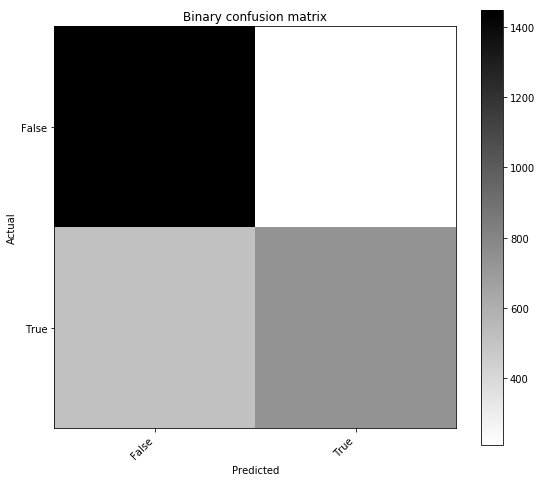

In [240]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [241]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8416705636962855


## Validation Sider

In [242]:
# sider_mod = pd.read_csv('../validation/Sider_val.csv')

In [243]:
# # Need to turn all to float
# import ast

# all_vecs = ['ChemGoVec', 'DisGoVec', 'disPhenVecMP', 'disPhenVecHP', 'CHEBIvec', 'DOvec', 
#             'dis_HINOvec', 'chem_HINOvec', ]

# for col in all_vecs:
#     sider_mod[col] = [ast.literal_eval(x) for x in sider_mod[col]]
#     sider_mod[col] = sider_mod[col].map(lambda x: [float(i) for i in x])

In [244]:
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(sider_mod.DisGoVec.values.tolist(), index= sider_mod.index)
# Cvecs = pd.DataFrame(sider_mod.ChemGoVec.values.tolist(), index= sider_mod.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(sider_mod.disPhenVecHP.values.tolist(), index= sider_mod.index)
# DHPvecs = pd.DataFrame(sider_mod.disPhenVecMP.values.tolist(), index= sider_mod.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(sider_mod.CHEBIvec.values.tolist(), index = sider_mod.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(sider_mod.DOvec.values.tolist(), index = sider_mod.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(sider_mod.dis_HINOvec.values.tolist(), index=sider_mod.index)
# cHINOvecs = pd.DataFrame(sider_mod.chem_HINOvec.values.tolist(), index=sider_mod.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [251]:
# Version for just gofunc vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:

Dvecs = pd.DataFrame(sider_mod.DisGoVec.values.tolist(), index= sider_mod.index)
Cvecs = pd.DataFrame(sider_mod.ChemGoVec.values.tolist(), index= sider_mod.index)
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [252]:
# Now create np array of the y output
all_y = np.array(sider_mod.Correlation)

In [259]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (1609,)
X shape:  (1609, 400)


1609

In [255]:
# Accuracy
test_loss, test_acc = model.evaluate(all_X, all_y)
print('Test accuracy:', test_acc)

1609/1609 [==============================] - 0s 95us/step
Test accuracy: 0.6059664388559411


In [256]:
# Get predictions
predictions = model.predict(all_X)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

In [257]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(all_y, predictions))

ROC AUC:  0.5218440600180014


In [268]:
print('Chems :', sider_mod.ChemicalID.nunique())
print('Dis :', sider_mod.MESH.nunique())
print('chem:dis obs: ', sider_mod.shape[0])
print('of which are uncorrelated: ', sider_mod[sider_mod.Correlation == 0].shape[0])

Chems : 38
Dis : 130
chem:dis obs:  1609
of which are uncorelated:  1006


In [250]:
# Error out to stop notebook
for a in i
def 


SyntaxError: invalid syntax (<ipython-input-250-440e5fd394b4>, line 2)

### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# test_set.DiseaseID.nunique()

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

In [ ]:
mem_usage(df_cd)

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# Save entire model to a HDF5 file
model.save('nn020219auc907.h5')

In [ ]:
# Save model (in two files, one for weights and one for json)
json_string = model.to_json()
model.save_weights("WEIGHTSnn020219auc907.h5")
with open('nn020219auc907.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [ ]:
from tensorflow.keras.models import load_model

model.save('nn020219auc907.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('nn020219auc907.h5')

In [ ]:
tf.default_session()

In [ ]:
from tensorflow.python.saved_model import tag_constants

with tf.Graph().as_default():
    with tf.Session as sess:
        ...

        # Saving
        inputs = {
            "batch_size_placeholder": batch_size_placeholder,
            "features_placeholder": features_placeholder,
            "labels_placeholder": labels_placeholder,
        }
        outputs = {"prediction": model_output}
        tf.saved_model.simple_save(
            sess, './', inputs, outputs
        )

In [ ]:
w1 = tf.Variable(tf.truncated_normal(shape=[10]), name='w1')
w2 = tf.Variable(tf.truncated_normal(shape=[20]), name='w2')
tf.add_to_collection('vars', w1)
tf.add_to_collection('vars', w2)
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, 'my-model')
# `save` method will call `export_meta_graph` implicitly.
# you will get saved graph files:my-model.meta